In [1]:
import json
import os
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
import pandas as pd
import seaborn as sns

pref_model_map = {
    'bbox=rf/baselinenam_st2': 'SurvNAM',
    'bbox=rf/bnamimp1_st2': 'SurvBNIM1',
    # 'bbox=rf/bnamimp2_st2': 'SurvBNIM2',
    # 'bbox=rf/baselineimportancesmlp_st2': 'SurvBeXMLP'
}

ds_dir_to_name_map = {
    'bnam/cox_dataset_clnum=2_fnum=5_cl_size=200': 'cox',
    'bnam/additive_funcs_dataset_clnum=1_fnum=5_cl_size=400': 'nonlinear',
    'bnam/cox_nonlinear=1_fnum=5_cl_size=400': 'nonlinear cox',
    'bnam/real_ds=breast_cancer': 'breast cancer',
    'bnam/real_ds=gbsg2': 'gbsg2',
    'bnam/real_ds=veterans': 'veterans',
    'bnam/real_ds=whas500': 'whas500'
}

exp_res_df = pd.DataFrame(
    [
        dict(
            ds_name=ds_name,
            model_name=model_name,
            res_dir=f"{ds_dir}/{model_pred_pref}"
        )
        for ds_dir, ds_name in ds_dir_to_name_map.items()
        for model_pred_pref, model_name in pref_model_map.items()
    ]
)

for key in ds_dir_to_name_map.keys():
    assert Path(key).exists(), key

exp_res_df

,ds_name,model_name,res_dir
0,cox,SurvNAM,bnam/cox_dataset_clnum=2_fnum=5_cl_size=200/bb...
1,cox,SurvBNIM1,bnam/cox_dataset_clnum=2_fnum=5_cl_size=200/bb...
2,nonlinear,SurvNAM,bnam/additive_funcs_dataset_clnum=1_fnum=5_cl_...
3,nonlinear,SurvBNIM1,bnam/additive_funcs_dataset_clnum=1_fnum=5_cl_...
4,nonlinear cox,SurvNAM,bnam/cox_nonlinear=1_fnum=5_cl_size=400/bbox=r...
5,nonlinear cox,SurvBNIM1,bnam/cox_nonlinear=1_fnum=5_cl_size=400/bbox=r...
6,breast cancer,SurvNAM,bnam/real_ds=breast_cancer/bbox=rf/baselinenam...
7,breast cancer,SurvBNIM1,bnam/real_ds=breast_cancer/bbox=rf/bnamimp1_st2
8,gbsg2,SurvNAM,bnam/real_ds=gbsg2/bbox=rf/baselinenam_st2
9,gbsg2,SurvBNIM1,bnam/real_ds=gbsg2/bbox=rf/bnamimp1_st2


In [2]:
grid_df = pd.DataFrame(
    [
        dict(
            res_dir=dir,
            grid_dir=f"{dir}/{subdir}"
        )

        for res_dir in list(exp_res_df['res_dir'])
        for dir, subdirs, files in os.walk(res_dir)
        for subdir in subdirs
    ]
)

for grid_dir in grid_df['grid_dir']:
    assert Path(grid_dir).exists()

grid_df

,res_dir,grid_dir
0,bnam/cox_dataset_clnum=2_fnum=5_cl_size=200/bb...,bnam/cox_dataset_clnum=2_fnum=5_cl_size=200/bb...
1,bnam/cox_dataset_clnum=2_fnum=5_cl_size=200/bb...,bnam/cox_dataset_clnum=2_fnum=5_cl_size=200/bb...
2,bnam/cox_dataset_clnum=2_fnum=5_cl_size=200/bb...,bnam/cox_dataset_clnum=2_fnum=5_cl_size=200/bb...
3,bnam/cox_dataset_clnum=2_fnum=5_cl_size=200/bb...,bnam/cox_dataset_clnum=2_fnum=5_cl_size=200/bb...
4,bnam/cox_dataset_clnum=2_fnum=5_cl_size=200/bb...,bnam/cox_dataset_clnum=2_fnum=5_cl_size=200/bb...
...,...,...
126,bnam/real_ds=whas500/bbox=rf/bnamimp1_st2,bnam/real_ds=whas500/bbox=rf/bnamimp1_st2/crit...
127,bnam/real_ds=whas500/bbox=rf/bnamimp1_st2,bnam/real_ds=whas500/bbox=rf/bnamimp1_st2/crit...
128,bnam/real_ds=whas500/bbox=rf/bnamimp1_st2,bnam/real_ds=whas500/bbox=rf/bnamimp1_st2/crit...
129,bnam/real_ds=whas500/bbox=rf/bnamimp1_st2,bnam/real_ds=whas500/bbox=rf/bnamimp1_st2/crit...


In [3]:
def parse_json(path):
    with open(path) as fp:
        return json.load(fp)


def parse_grid_exp(grid_dir: str):
    grid_args = parse_json(f"{grid_dir}/grid_args.json")
    history = parse_json(f"{grid_dir}/history.json")
    return {
        **grid_args,
        **pd.DataFrame(history['history']).sort_values('target_loss', ascending=True).iloc[0].to_dict()
    }


grid_res_df = pd.DataFrame(
    [
        {
            'res_dir': res_dir,
            'grid_dir': grid_dir,
            **parse_grid_exp(grid_dir)
        }
        for res_dir, grid_dir in grid_df[['res_dir', 'grid_dir']].itertuples(index=False)
    ]
)

res_df = pd.merge(left=exp_res_df, right=grid_res_df, left_on='res_dir', right_on='res_dir')
res_df

,ds_name,model_name,res_dir,grid_dir,criterion,last_layer,max_epoch,mode,nam_args,optimizer,optimizer_args,v_mode,target_loss,train_loss,val_loss,target_cindex,val_cindex,train_cindex
0,cox,SurvNAM,bnam/cox_dataset_clnum=2_fnum=5_cl_size=200/bb...,bnam/cox_dataset_clnum=2_fnum=5_cl_size=200/bb...,mse,relu,10,surv,{},adam,"{'lr': 0.001, 'weight_decay': 0}",no_surv,0.011097,0.024501,0.011234,0.757039,0.844444,0.566330
1,cox,SurvNAM,bnam/cox_dataset_clnum=2_fnum=5_cl_size=200/bb...,bnam/cox_dataset_clnum=2_fnum=5_cl_size=200/bb...,mse,relu,10,surv,{},adam,"{'lr': 0.01, 'weight_decay': 0}",no_surv,0.014122,0.018513,0.017573,0.648200,0.688889,0.531404
2,cox,SurvNAM,bnam/cox_dataset_clnum=2_fnum=5_cl_size=200/bb...,bnam/cox_dataset_clnum=2_fnum=5_cl_size=200/bb...,mse,relu,20,surv,{},adam,"{'lr': 0.0001, 'weight_decay': 0}",no_surv,0.008954,0.021066,0.010585,0.763031,0.800000,0.569291
3,cox,SurvNAM,bnam/cox_dataset_clnum=2_fnum=5_cl_size=200/bb...,bnam/cox_dataset_clnum=2_fnum=5_cl_size=200/bb...,mse,relu,20,surv,{},adam,"{'lr': 0.001, 'weight_decay': 0}",no_surv,0.006200,0.013480,0.008104,0.837277,0.866667,0.712269
4,cox,SurvNAM,bnam/cox_dataset_clnum=2_fnum=5_cl_size=200/bb...,bnam/cox_dataset_clnum=2_fnum=5_cl_size=200/bb...,mse,relu,20,surv,{},adam,"{'lr': 0.01, 'weight_decay': 0}",no_surv,0.014310,0.022546,0.015807,0.503493,0.500000,0.490789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,whas500,SurvBNIM1,bnam/real_ds=whas500/bbox=rf/bnamimp1_st2,bnam/real_ds=whas500/bbox=rf/bnamimp1_st2/crit...,mse,relu,10,surv,"{'kernel_width': 0.1, 'kernel_name': 'nn', 'no...",adam,"{'lr': 0.0001, 'weight_decay': 0.0001}",no_surv,0.338940,0.528782,0.376926,0.664679,0.607143,0.647808
127,whas500,SurvBNIM1,bnam/real_ds=whas500/bbox=rf/bnamimp1_st2,bnam/real_ds=whas500/bbox=rf/bnamimp1_st2/crit...,mse,relu,10,surv,"{'kernel_width': 0.1, 'kernel_name': 'nn', 'no...",adam,"{'lr': 0.0001, 'weight_decay': 1e-05}",no_surv,0.107828,0.285187,0.087987,0.772193,0.767857,0.702805
128,whas500,SurvBNIM1,bnam/real_ds=whas500/bbox=rf/bnamimp1_st2,bnam/real_ds=whas500/bbox=rf/bnamimp1_st2/crit...,mse,relu,10,surv,"{'kernel_width': 0.1, 'kernel_name': 'nn', 'no...",adam,"{'lr': 0.0001, 'weight_decay': 1e-06}",no_surv,0.043864,0.134330,0.022221,0.858334,0.821429,0.799202
129,whas500,SurvBNIM1,bnam/real_ds=whas500/bbox=rf/bnamimp1_st2,bnam/real_ds=whas500/bbox=rf/bnamimp1_st2/crit...,mse,relu,10,surv,"{'kernel_width': 0.1, 'kernel_name': 'nn', 'no...",adam,"{'lr': 0.0001, 'weight_decay': 1e-07}",no_surv,0.036951,0.117668,0.021549,0.868564,0.821429,0.825542


In [4]:
best_res_df = []
for ds_name in res_df['ds_name'].unique():
    for model_name in res_df['model_name'].unique():
        model_exp = res_df[(res_df['model_name'] == model_name) & (res_df['ds_name'] == ds_name)].copy()
        model_exp['select_loss'] = model_exp['train_loss']
        best_res_df.append(
            model_exp.sort_values('select_loss', ascending=True).drop(columns=['select_loss']).iloc[0].to_dict())

best_res_df = pd.DataFrame(best_res_df)
best_res_df

,ds_name,model_name,res_dir,grid_dir,criterion,last_layer,max_epoch,mode,nam_args,optimizer,optimizer_args,v_mode,target_loss,train_loss,val_loss,target_cindex,val_cindex,train_cindex
0,cox,SurvNAM,bnam/cox_dataset_clnum=2_fnum=5_cl_size=200/bb...,bnam/cox_dataset_clnum=2_fnum=5_cl_size=200/bb...,mse,relu,20,surv,{},adam,"{'lr': 0.001, 'weight_decay': 0}",no_surv,0.006200,0.013480,0.008104,0.837277,0.866667,0.712269
1,cox,SurvBNIM1,bnam/cox_dataset_clnum=2_fnum=5_cl_size=200/bb...,bnam/cox_dataset_clnum=2_fnum=5_cl_size=200/bb...,mse,relu,20,surv,"{'kernel_width': 0.1, 'kernel_name': 'nn', 'no...",adam,"{'lr': 0.0001, 'weight_decay': 0}",no_surv,0.002102,0.001418,0.001590,0.907403,0.955556,0.933296
2,nonlinear,SurvNAM,bnam/additive_funcs_dataset_clnum=1_fnum=5_cl_...,bnam/additive_funcs_dataset_clnum=1_fnum=5_cl_...,mse,relu,10,surv,{},adam,"{'lr': 0.0001, 'weight_decay': 1e-05}",no_surv,0.001041,0.001964,0.000860,0.901328,0.897436,0.900351
3,nonlinear,SurvBNIM1,bnam/additive_funcs_dataset_clnum=1_fnum=5_cl_...,bnam/additive_funcs_dataset_clnum=1_fnum=5_cl_...,mse,relu,10,surv,"{'kernel_width': 0.1, 'kernel_name': 'nn', 'no...",adam,"{'lr': 0.0001, 'weight_decay': 1e-07}",no_surv,0.000335,0.000347,0.000211,0.925429,0.948718,0.953205
4,nonlinear cox,SurvNAM,bnam/cox_nonlinear=1_fnum=5_cl_size=400/bbox=r...,bnam/cox_nonlinear=1_fnum=5_cl_size=400/bbox=r...,mse,relu,10,surv,{},adam,"{'lr': 0.0001, 'weight_decay': 0}",no_surv,0.001280,0.001756,0.001277,0.901011,0.925926,0.833517
5,nonlinear cox,SurvBNIM1,bnam/cox_nonlinear=1_fnum=5_cl_size=400/bbox=r...,bnam/cox_nonlinear=1_fnum=5_cl_size=400/bbox=r...,mse,relu,10,surv,"{'kernel_width': 0.1, 'kernel_name': 'nn', 'no...",adam,"{'lr': 0.0001, 'weight_decay': 1e-08}",no_surv,0.000905,0.001027,0.000533,0.909337,0.962963,0.918680
6,breast cancer,SurvNAM,bnam/real_ds=breast_cancer/bbox=rf/baselinenam...,bnam/real_ds=breast_cancer/bbox=rf/baselinenam...,mse,relu,10,surv,{},adam,"{'lr': 0.0001, 'weight_decay': 1e-07}",no_surv,0.686056,2.011871,0.509114,0.624247,0.500000,0.637782
7,breast cancer,SurvBNIM1,bnam/real_ds=breast_cancer/bbox=rf/bnamimp1_st2,bnam/real_ds=breast_cancer/bbox=rf/bnamimp1_st...,mse,relu,10,surv,"{'kernel_width': 0.1, 'kernel_name': 'nn', 'no...",adam,"{'lr': 0.0001, 'weight_decay': 1e-05}",no_surv,0.670166,2.031700,0.506605,0.730843,0.750000,0.802846
8,gbsg2,SurvNAM,bnam/real_ds=gbsg2/bbox=rf/baselinenam_st2,bnam/real_ds=gbsg2/bbox=rf/baselinenam_st2/cri...,mse,relu,10,surv,{},adam,"{'lr': 0.0001, 'weight_decay': 1e-06}",no_surv,0.099349,0.202924,0.057246,0.627280,0.903226,0.562105
9,gbsg2,SurvBNIM1,bnam/real_ds=gbsg2/bbox=rf/bnamimp1_st2,bnam/real_ds=gbsg2/bbox=rf/bnamimp1_st2/criter...,mse,relu,10,surv,"{'kernel_width': 0.1, 'kernel_name': 'nn', 'no...",adam,"{'lr': 0.0001, 'weight_decay': 0}",no_surv,0.049843,0.109610,0.035417,0.807904,0.806452,0.719910


In [13]:
best_res_df.rename(
    columns={
        'train_loss': 'background_loss',
        'train_cindex': 'background_cindex',
        'val_loss': 'exp_loss',
        'val_cindex': 'exp_cindex'
    },
    inplace=True
)
cindex_metrics = [key for key in best_res_df.keys() if 'cindex' in key]
loss_metrics = [key for key in best_res_df.keys() if 'loss' in key]
assert len(cindex_metrics) == len(loss_metrics)

group_df = best_res_df[['ds_name', 'model_name', *cindex_metrics]].groupby(['ds_name', 'model_name']).mean().round(4)
group_df[[pair[0] == 'whas500' for pair in group_df.index]]

target_cindex  exp_cindex  background_cindex
ds_name model_name                                              
whas500 SurvBNIM1          0.8690      0.8214             0.8249
        SurvNAM            0.8129      0.7500             0.7123

In [6]:
def move_to_best_dir(grid_dir, res_dir, model_name):
    grid_dir = Path(grid_dir)
    dest_dir = Path(res_dir).parent.joinpath('a_best_grid_results')
    model_name = Path(model_name)
    dest_dir.mkdir(exist_ok=True, parents=True)
    shutil.copy(src=grid_dir.joinpath('shape_functions.png'),
                dst=dest_dir.joinpath(f'{model_name}_shape_functions.png'))

    for pref in ['_der', '_der_abs', '_der_abs_sigm', '_der_abs_first_sigm', '']:
        fname = f"shape_functions{pref}.png"
        fpath = grid_dir.joinpath(fname)
        if fpath.exists():
            dest_path = dest_dir.joinpath(f'{model_name}_{fname}')
            shutil.copy(src=fpath, dst=dest_path)
            print(f'{fpath}\nmoved to\n{dest_path}\n')
        else:
            print(f'{fpath} not exists\n')
            pass


for grid_dir, res_dir, model_name in best_res_df[['grid_dir', 'res_dir', 'model_name']].itertuples(index=False):
    if model_name == 'SurvBeXMLP':
        continue
    move_to_best_dir(grid_dir=grid_dir, res_dir=res_dir, model_name=model_name)

bnam\cox_dataset_clnum=2_fnum=5_cl_size=200\bbox=rf\baselinenam_st2\criterion=mse,last_layer=relu,max_epoch=20,mode=surv,optimizer=adam,v_mode=no_surv,,lr=0.001,weight_decay=0\shape_functions_der.png not exists

bnam\cox_dataset_clnum=2_fnum=5_cl_size=200\bbox=rf\baselinenam_st2\criterion=mse,last_layer=relu,max_epoch=20,mode=surv,optimizer=adam,v_mode=no_surv,,lr=0.001,weight_decay=0\shape_functions_der_abs.png not exists

bnam\cox_dataset_clnum=2_fnum=5_cl_size=200\bbox=rf\baselinenam_st2\criterion=mse,last_layer=relu,max_epoch=20,mode=surv,optimizer=adam,v_mode=no_surv,,lr=0.001,weight_decay=0\shape_functions_der_abs_sigm.png not exists

bnam\cox_dataset_clnum=2_fnum=5_cl_size=200\bbox=rf\baselinenam_st2\criterion=mse,last_layer=relu,max_epoch=20,mode=surv,optimizer=adam,v_mode=no_surv,,lr=0.001,weight_decay=0\shape_functions_der_abs_first_sigm.png not exists

bnam\cox_dataset_clnum=2_fnum=5_cl_size=200\bbox=rf\baselinenam_st2\criterion=mse,last_layer=relu,max_epoch=20,mode=surv,opt

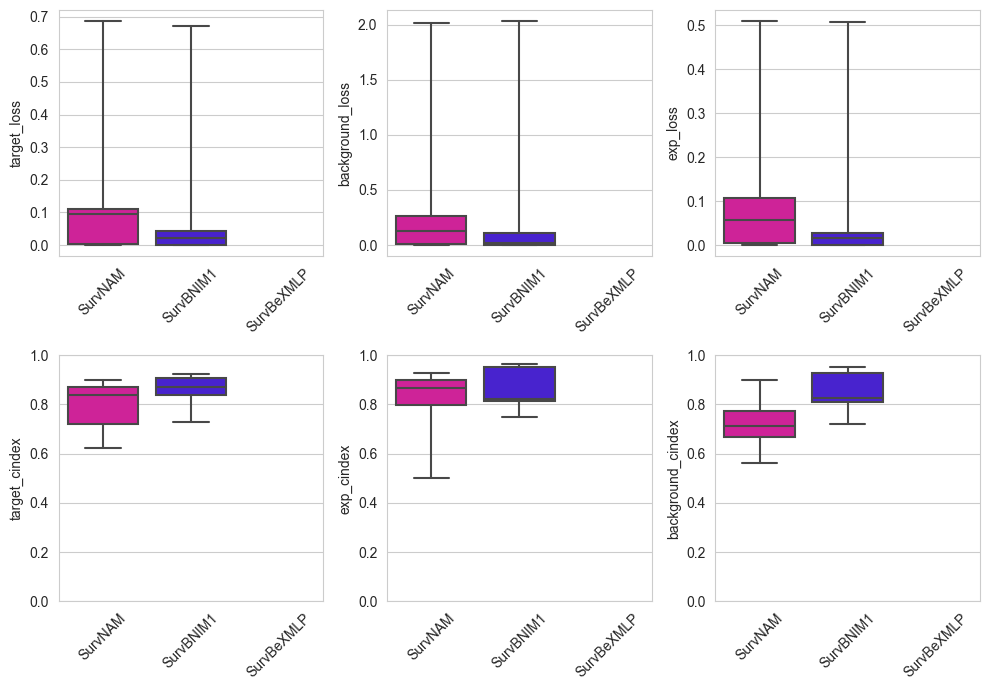

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=len(loss_metrics), figsize=(10, 7))

models_colors = {
    'SurvBNIM1': '#3807ea',
    # 'SurvBNIM2': '#bd07ea',
    'SurvBeXMLP': '#bd07ea',
    'SurvNAM': '#ea07a2'
}

for rowi, metrics_set in enumerate((loss_metrics, cindex_metrics)):
    for col_i, mname in enumerate(metrics_set):
        ax = axes[rowi, col_i]
        sns.boxplot(data=best_res_df, x='model_name', y=mname, whis=1000,
                    order=['SurvNAM', 'SurvBNIM1'], palette=models_colors, ax=ax)
        ax.set_xlabel('')
        ax.set_ylabel(mname)
        ax.tick_params(axis='x', labelrotation=45)
        if 'cindex' in mname:
            ax.set_ylim((0, 1))

plt.tight_layout()